# Wide and Deep Model for Recommender Systems

In [2]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [5]:
# ratings = pd.read_csv('../../data/lens_tmdb/ratings.csv')
ratings = pd.read_csv('../../data/lens_tmdb/ratings_small.csv')
info = pd.read_csv('../../data/lens_tmdb/cleaned/df_all.csv')

In [6]:
ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [7]:
# Encode users and movies as integer indices
user_enc = LabelEncoder()
ratings['userId'] = user_enc.fit_transform(ratings['userId'].values)
n_users = ratings['userId'].nunique()

movie_enc = LabelEncoder()
ratings['movieId'] = movie_enc.fit_transform(ratings['movieId'].values)
n_movies = ratings['movieId'].nunique()

# Split data into train and test sets
train, test = train_test_split(ratings, test_size=0.2, random_state=42)


# Creating Dataloaders

In [8]:
class MovieLensDataset(Dataset):
    def __init__(self, ratings):
        self.users = ratings['userId'].values
        self.movies = ratings['movieId'].values
        self.ratings = ratings['rating'].values

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.ratings[idx]


# Wide and Deep Model Architecture

In [9]:
class WideAndDeepModel(nn.Module):
    def __init__(self, n_users, n_movies, n_factors, embedding_dropout, hidden_layers, dropouts):
        super().__init__()

        # Embeddings
        self.user_embedding = nn.Embedding(n_users, n_factors)
        self.movie_embedding = nn.Embedding(n_movies, n_factors)
        self.embedding_dropout = nn.Dropout(embedding_dropout)

        # Linear Layers
        self.hidden_layers = nn.ModuleList([nn.Linear(n_factors*2, hidden_layers[0])])
        for i in range(1, len(hidden_layers)):
            self.hidden_layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
        self.output_layer = nn.Linear(hidden_layers[-1], 1)

        # Dropout Layers
        self.dropout_layers = nn.ModuleList([nn.Dropout(dropout) for dropout in dropouts])

    def forward(self, users, movies):
        user_embeds = self.user_embedding(users)
        movie_embeds = self.movie_embedding(movies)

        # Combine the embeddings (concatenate)
        x = torch.cat([user_embeds, movie_embeds], dim=1)
        x = self.embedding_dropout(x)

        # Pass through the hidden layers
        for hidden_layer, dropout_layer in zip(self.hidden_layers, self.dropout_layers):
            x = hidden_layer(x)
            x = nn.ReLU()(x)
            x = dropout_layer(x)

        # Output layer
        out = self.output_layer(x)

        return out


In [10]:
# Evaluation metrics
def mae(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return torch.mean((y_true - y_pred)**2)

def rmse(y_true, y_pred):
    return torch.sqrt(mse(y_true, y_pred))

# Training and test the Model

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize DataLoader
train_loader = DataLoader(MovieLensDataset(train), batch_size=1024, shuffle=True)
test_loader = DataLoader(MovieLensDataset(test), batch_size=1024)

# Create the model
model = WideAndDeepModel(n_users, n_movies, n_factors=50, embedding_dropout=0.05, hidden_layers=[128, 64], dropouts=[0.5, 0.5]).to(device)

# Define the criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []
train_maes = []
test_maes = []
train_mses = []
test_mses = []
train_rmses = []
test_rmses = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_mae_val = 0
    train_mse_val = 0
    train_rmse_val = 0
    for users, movies, ratings in train_loader:
        users = users.to(device)
        movies = movies.to(device)
        ratings = ratings.float().to(device)

        optimizer.zero_grad()
        outputs = model(users, movies).squeeze()
        loss = criterion(outputs, ratings)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_mae_val += mae(outputs, ratings).item()
        train_mse_val += mse(outputs, ratings).item()
        train_rmse_val += rmse(outputs, ratings).item()

    train_loss /= len(train_loader)
    train_maes.append(train_mae_val/len(train_loader))
    train_mses.append(train_mse_val/len(train_loader))
    train_rmses.append(train_rmse_val/len(train_loader))
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0
    test_mae_val = 0
    test_mse_val = 0
    test_rmse_val = 0
    with torch.no_grad():
        for users, movies, ratings in test_loader:
            users = users.to(device)
            movies = movies.to(device)
            ratings = ratings.float().to(device)

            outputs = model(users, movies).squeeze()
            loss = criterion(outputs, ratings)

            test_loss += loss.item()
            test_mae_val += mae(outputs, ratings).item()
            test_mse_val += mse(outputs, ratings).item()
            test_rmse_val += rmse(outputs, ratings).item()

    test_loss /= len(test_loader)
    test_maes.append(test_mae_val/len(test_loader))
    test_mses.append(test_mse_val/len(test_loader))
    test_rmses.append(test_rmse_val/len(test_loader))
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Test Loss: {test_loss}")
    print(f"Epoch {epoch+1}/{num_epochs}, Train MAE: {train_maes[-1]}, Test MAE: {test_maes[-1]}")
    print(f"Epoch {epoch+1}/{num_epochs}, Train MSE: {train_mses[-1]}, Test MSE: {test_mses[-1]}")
    print(f"Epoch {epoch+1}/{num_epochs}, Train RMSE: {train_rmses[-1]}, Test RMSE: {test_rmses[-1]}")

Epoch 1/10, Train Loss: 3.6973946366129042, Test Loss: 1.1284986078739165
Epoch 1/10, Train MAE: 1.5419549361059937, Test MAE: 0.8591250389814377
Epoch 1/10, Train MSE: 3.6973946366129042, Test MSE: 1.1284986078739165
Epoch 1/10, Train RMSE: 1.794443190852298, Test RMSE: 1.0621156990528107
Epoch 2/10, Train Loss: 1.6851156648201278, Test Loss: 1.1007150709629059
Epoch 2/10, Train MAE: 1.0431364337100257, Test MAE: 0.8549594938755035
Epoch 2/10, Train MSE: 1.6851156648201278, Test MSE: 1.1007150709629059
Epoch 2/10, Train RMSE: 1.2976025086414964, Test RMSE: 1.048994815349579
Epoch 3/10, Train Loss: 1.569497897655149, Test Loss: 1.0297798424959184
Epoch 3/10, Train MAE: 1.0064691101448446, Test MAE: 0.8198142111301422
Epoch 3/10, Train MSE: 1.569497897655149, Test MSE: 1.0297798424959184
Epoch 3/10, Train RMSE: 1.252504271796987, Test RMSE: 1.0146363973617554
Epoch 4/10, Train Loss: 1.5232558989826637, Test Loss: 1.0082991629838944
Epoch 4/10, Train MAE: 0.9899520111989372, Test MAE: 0.

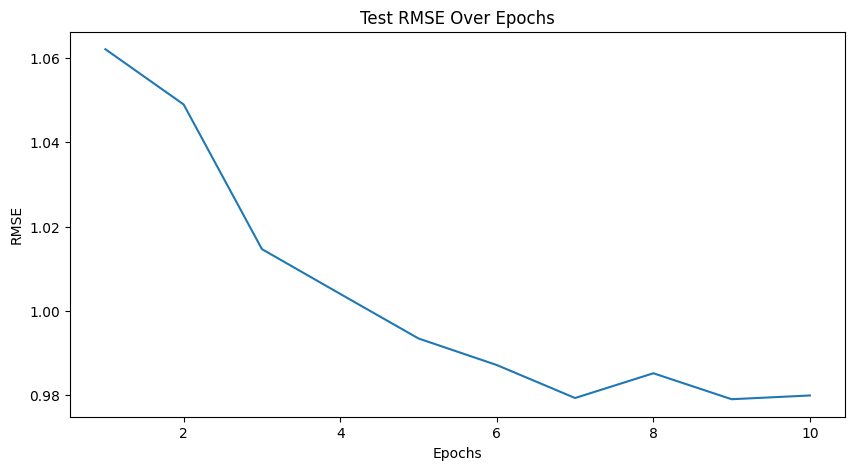

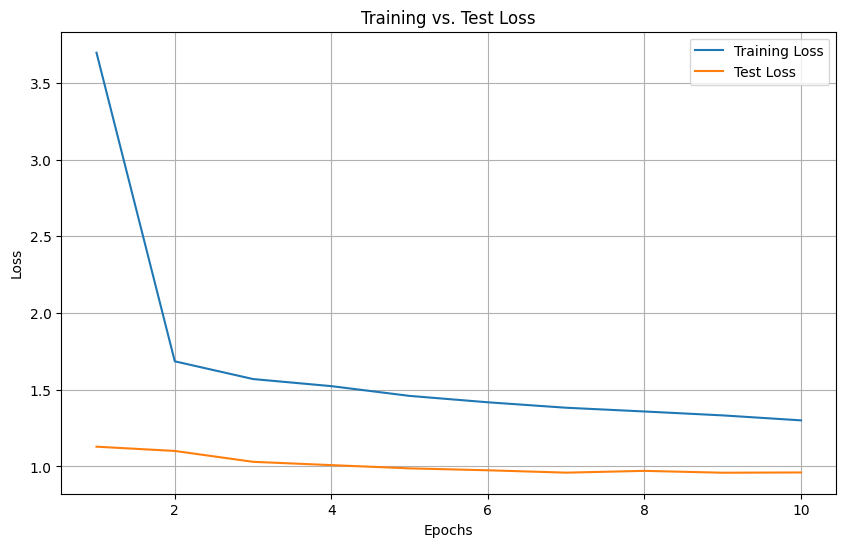

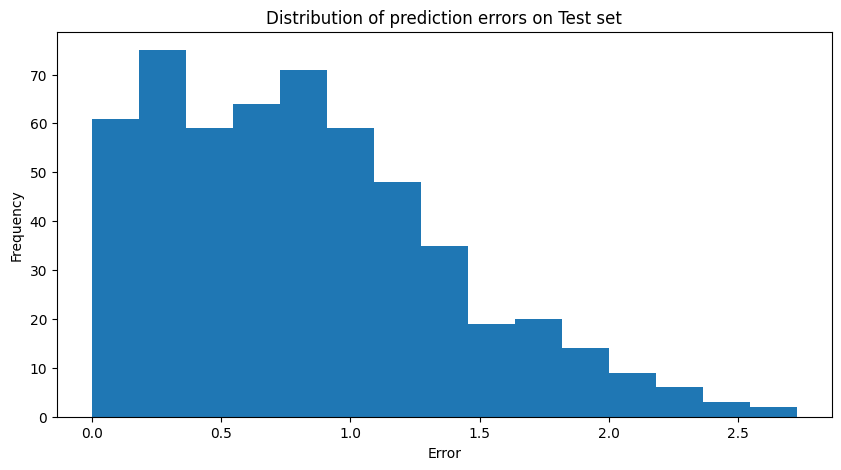

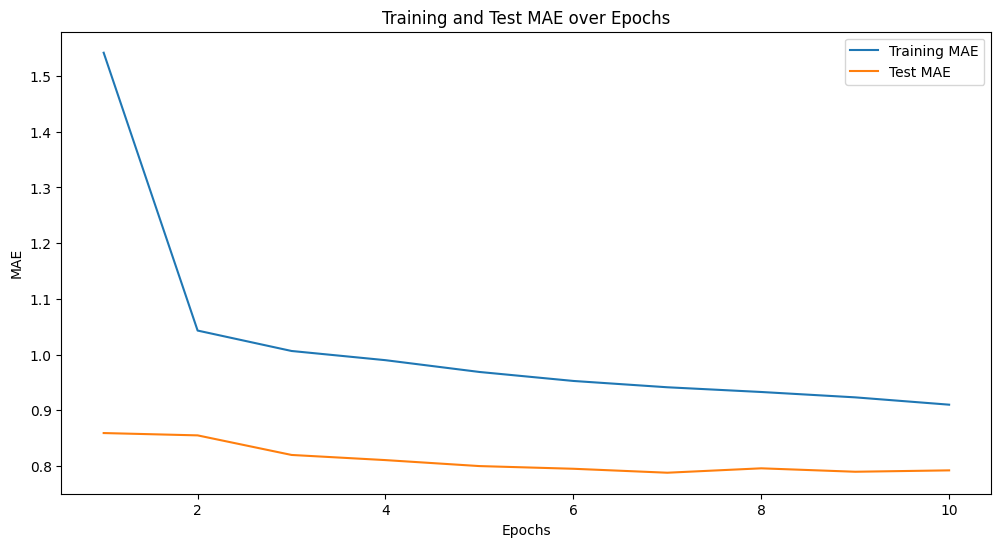

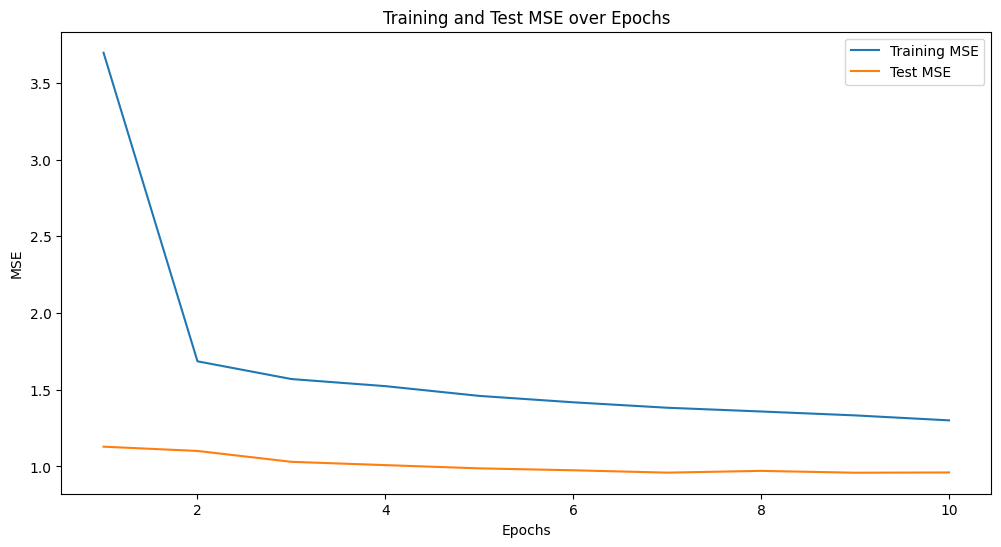

In [13]:
# Plotting losses
import matplotlib.pyplot as plt
epochs = range(1, num_epochs + 1)

# To visualize the RMSE over epochs
plt.figure(figsize=(10,5))
plt.plot(epochs, test_rmses)
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Test RMSE Over Epochs')
plt.show()

# To visualize the training and test losses
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, test_losses, label="Test Loss")
plt.title("Training vs. Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# To visualize the distribution of errors on test data
errors = torch.abs(outputs - ratings).view(-1).cpu().numpy()

plt.figure(figsize=(10,5))
plt.hist(errors, bins='auto')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Distribution of prediction errors on Test set')
plt.show()


# Additional plots for MAE and MSE
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_maes, label='Training MAE')
plt.plot(epochs, test_maes, label='Test MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Training and Test MAE over Epochs')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mses, label='Training MSE')
plt.plot(epochs, test_mses, label='Test MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.title('Training and Test MSE over Epochs')
plt.show()